In [1]:
from similarity_searching_sketches.persistence import load_np_array, save_np_array
from similarity_searching_sketches.approx_evaluation import compute_knn_results
from similarity_searching_sketches.approx_evaluation import sort_ids_by_distance
from similarity_searching_sketches.distances import hamming
from similarity_searching_sketches.distances import l1
from similarity_searching_sketches.sketch_producer import MinkowskiSketchProducer
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.utils import percentage
from similarity_searching_sketches.partitioning import balance_score
from similarity_searching_sketches.correlation_matrix import compute_corr_mtx
from similarity_searching_sketches.correlation_matrix import get_upper_triangle_values
from similarity_searching_sketches.multi_hash_index_stats import stats_to_pandas
from similarity_searching_sketches.multi_hash_index_stats import ListStatsCounter
from similarity_searching_sketches.utils import df_to_latex
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH=DATA_FOLDER+'selected_pivots.npy'
MHI_DB_SAVE_PATH=DATA_FOLDER+'mhi_sketch_db.npy'
TRAIN_SUFFIX='train_set.npy'
TEST_SUFFIX='test_set.npy'
DB_PATH_PREFIX='db_'
QUERY_OBJ_PATH_PREFIX='query_obj_'
KNN_RES_PREFIX='knn_res_'
N_QUERY_OBJS=100
K=100
TESTED_SKETCH_LENGTHS=[2,4,8,16,32,64,128]
FILTERING_SPLITS=10
LOG_BY=5000
TRAIN_RECALL_SAVE_PATH=DATA_FOLDER+'train_recall.tex'
TEST_RECALL_SAVE_PATH=DATA_FOLDER+'test_recall.tex'
RECALL_DIFF_SAVE_PATH=DATA_FOLDER+'recall_diff.tex'
TRAIN_VS_TEST_LATEX_SAVE_PATH=DATA_FOLDER+'train_vs_test.tex'



#### Generate database and compute k-NN results

In [3]:
def compute_knn(suffix):
    dataset=load_np_array(DATA_FOLDER+suffix)
    np.random.shuffle(dataset)
    queries, dataset=np.split(dataset,[N_QUERY_OBJS])
    ids=np.arange(dataset.shape[0])
    knn_results=compute_knn_results(ids, dataset, queries, K, l1, log_by=LOG_BY)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+suffix, dataset)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+'ids_'+suffix, ids)
    save_np_array(DATA_FOLDER+QUERY_OBJ_PATH_PREFIX+suffix, queries)
    save_np_array(DATA_FOLDER+KNN_RES_PREFIX+suffix, knn_results)
    return ids,dataset,queries,knn_results
    

In [4]:
ids_train, vecs_train, queries_train, knn_res_train = compute_knn(TRAIN_SUFFIX)
ids_test, vecs_test, queries_test, knn_res_test = compute_knn(TEST_SUFFIX)

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 13.830764293670654s
 Time from start: 13.830764770507812s


In [5]:
vecs_train.shape

(7900, 4096)

#### Transform database and queries to Sketches

In [6]:
sketch_producer=MinkowskiSketchProducer(pivots_path=PIVOTS_PATH,p=1)

In [7]:
sketches_train=sketch_producer.transform_many(vecs_train)
sketches_queries_train=sketch_producer.transform_many(queries_train)

sketches_test=sketch_producer.transform_many(vecs_test)
sketches_queries_test=sketch_producer.transform_many(queries_test)

In [8]:
sketches_train.shape

(7900, 128)

Save data for MHI experiments

In [9]:
save_np_array(MHI_DB_SAVE_PATH,np.concatenate((sketches_train, sketches_test, sketches_queries_train, sketches_queries_test)))

#### Evaluate approximation quality

In [10]:
def get_sorted_ids(ids, sketches, sketch_queries, sketch_len):
    sketches_shortedned=sketches.T[:sketch_len].T
    sketch_queries_shortened=sketch_queries.T[:sketch_len].T
    return sort_ids_by_distance(ids_train, sketches_shortedned, sketch_queries_shortened, hamming)

sorted_ids_list_train=[]
sorted_ids_list_test=[]

for sketch_len in TESTED_SKETCH_LENGTHS:
    sorted_ids_list_train.append((sketch_len,get_sorted_ids(ids_train, sketches_train,sketches_queries_train, sketch_len)))
    sorted_ids_list_test.append((sketch_len,get_sorted_ids(ids_test, sketches_test,sketches_queries_test, sketch_len)))

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.809927225112915s
 Time from start: 0.8099281787872314s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.789548397064209s
 Time from start: 0.7895491123199463s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7991037368774414s
 Time from start: 0.7991042137145996s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8051302433013916s
 Time from start: 0.8051309585571289s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8166139125823975s
 Time from start: 0.8166143894195557s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8386070728302002s
 Time from start: 0.8386080265045166s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8503990173339844s
 Time from start: 0.8503997325897217s


In [11]:
def evaluate_approximation_quality(sorted_ids, true_knn, sketch_len, text_prefix):
    filtering_counts=range(0, sorted_ids.shape[1], int(sorted_ids.shape[1]/FILTERING_SPLITS))
    percentages=[100-int(percentage(cnt, sorted_ids.shape[1])) for cnt in filtering_counts]
    mean_intersection=list()
    for count in filtering_counts:
        intersection_sizes=[]
        for i in range(true_knn.shape[0]):
            intersection_sizes.append(len(set(true_knn[i])&set(sorted_ids[i][:count])))
        mean_intersection.append(np.mean(intersection_sizes))
    return mean_intersection

#### Approximation quality Train set

In [12]:
recalls_train=[]

In [13]:
for (sketch_len, sorted_ids) in sorted_ids_list_train:
    recalls_train.append(evaluate_approximation_quality(sorted_ids, knn_res_train, sketch_len, text_prefix='Train set: '))

In [14]:
recalls_test=[]
for (sketch_len, sorted_ids) in sorted_ids_list_test:
    recalls_test.append(evaluate_approximation_quality(sorted_ids, knn_res_test, sketch_len, text_prefix='Test set: '))

#### Analyze Recall for train and test set

In [15]:
keys_perc=[str(num)+'% db searched' for num in [int(percentage(cnt, sorted_ids.shape[1])) for cnt in range(0, sorted_ids.shape[1], int(sorted_ids.shape[1]/FILTERING_SPLITS))] if num>0]
keys_test=['p='+str(sk_len) for sk_len in TESTED_SKETCH_LENGTHS]
keys_train=['p='+str(sk_len) for sk_len in TESTED_SKETCH_LENGTHS]
stats_test={key:recalls_test[i] for i,key in enumerate(keys_test)}
stats_train={key:recalls_train[i] for i,key in enumerate(keys_train)}
df_recall_train=stats_to_pandas(keys_train,stats_train)[1:]
df_recall_test=stats_to_pandas(keys_test,stats_test)[1:]
df_recall_train.index=keys_perc
df_recall_test.index=keys_perc

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


#### % Recall train set

In [16]:
df_to_latex(TRAIN_RECALL_SAVE_PATH,df_recall_train)
df_recall_train

,p=2,p=4,p=8,p=16,p=32,p=64,p=128
10% db searched,19.14,27.55,36.87,48.86,61.42,76.35,87.18
20% db searched,38.77,48.82,54.51,67.33,78.41,89.21,95.41
30% db searched,56.67,61.99,67.46,78.31,87.41,94.61,97.95
40% db searched,69.03,72.37,76.39,85.70,92.64,97.19,99.02
50% db searched,76.27,80.36,83.67,91.01,95.70,98.75,99.54
60% db searched,83.41,87.07,88.98,94.72,97.80,99.39,99.79
70% db searched,89.14,91.45,93.32,97.20,99.12,99.76,99.93
80% db searched,94.20,95.42,96.75,98.71,99.67,99.94,99.99
90% db searched,97.81,98.26,98.86,99.60,99.93,100.00,100.00


#### % Recall test set

In [17]:
df_to_latex(TEST_RECALL_SAVE_PATH, df_recall_test)
df_recall_test

,p=2,p=4,p=8,p=16,p=32,p=64,p=128
10% db searched,17.45,24.73,28.95,36.34,45.52,57.29,67.21
20% db searched,35.34,44.04,46.66,55.22,65.38,77.44,85.55
30% db searched,51.24,56.91,59.75,68.55,77.69,87.03,92.95
40% db searched,63.05,67.63,69.53,77.95,85.51,92.51,96.16
50% db searched,72.10,75.10,78.24,84.70,90.80,95.85,97.78
60% db searched,80.24,82.73,85.18,89.96,94.65,97.72,98.86
70% db searched,86.84,88.57,90.59,94.21,97.11,98.88,99.46
80% db searched,92.63,93.78,94.92,97.08,98.63,99.61,99.81
90% db searched,97.16,97.02,98.10,98.89,99.58,99.90,99.98


#### % Recall difference between train and test set

In [18]:
recall_differences=df_recall_train-df_recall_test
df_to_latex(RECALL_DIFF_SAVE_PATH, recall_differences)
recall_differences

,p=2,p=4,p=8,p=16,p=32,p=64,p=128
10% db searched,1.69,2.82,7.92,12.52,15.90,19.06,19.97
20% db searched,3.43,4.78,7.85,12.11,13.03,11.77,9.86
30% db searched,5.43,5.08,7.71,9.76,9.72,7.58,5.00
40% db searched,5.98,4.74,6.86,7.75,7.13,4.68,2.86
50% db searched,4.17,5.26,5.43,6.31,4.90,2.90,1.76
60% db searched,3.17,4.34,3.80,4.76,3.15,1.67,0.93
70% db searched,2.30,2.88,2.73,2.99,2.01,0.88,0.47
80% db searched,1.57,1.64,1.83,1.63,1.04,0.33,0.18
90% db searched,0.65,1.24,0.76,0.71,0.35,0.10,0.02


#### Plot recall

In [19]:
def plot_recall(df,title):
    df.index=[item[:2] for item in recall_differences.index]
    df.plot(figsize=(6,6))
    plt.title(title)
    plt.xlabel('% db searched')
    plt.ylabel('% recall')
    plt.show()

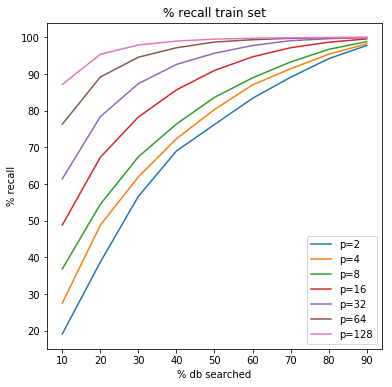

In [20]:
plot_recall(df_recall_train,title='% recall train set')

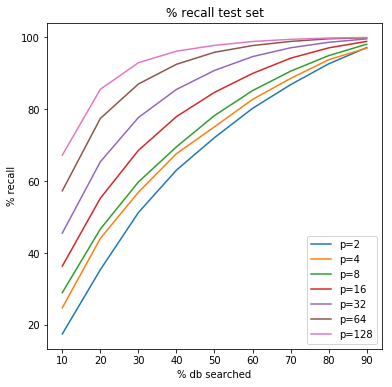

In [21]:
plot_recall(df_recall_test,title='% recall test set')

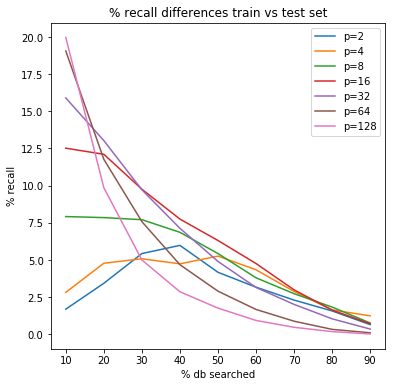

In [22]:
plot_recall(recall_differences,title='% recall differences train vs test set')


#### Evaluate Sketch properties train set vs test set

In [23]:
train_set=np.concatenate((sketches_train, sketches_queries_train))
train_set.shape

(8000, 128)

In [24]:
test_set=np.concatenate((sketches_test, sketches_queries_test))
test_set.shape

(2000, 128)

In [25]:
def mean_balance_score(sketch_set, sketch_size):
    sketches=sketch_set.T[:sketch_size].T
    counts_one=np.zeros(sketches.shape[1])
    for i in range(sketches.shape[0]):
        for j in range(sketches.shape[1]):
            if sketches[i][j]==1:
                counts_one[j]+=1
    return np.mean([balance_score(cnt, sketches.shape[0]) for cnt in counts_one])

def mean_corr(sketch_set,sketch_size):
    sketches=sketch_set.T[:sketch_size].T
    corr_mtx=compute_corr_mtx(sketches)
    return np.mean(get_upper_triangle_values(corr_mtx))
    
    

In [26]:
keys=['p','Balance score train','Corr train','Balance score test','Corr test','Balance score diff', 'Corr diff']
stats={key:[] for key in keys}
for length in TESTED_SKETCH_LENGTHS:
    bal_train=mean_balance_score(train_set,length)
    bal_test=mean_balance_score(test_set,length)
    corr_train=mean_corr(train_set,length)
    corr_test=mean_corr(test_set,length)
    stats['p'].append(length)
    stats['Balance score test'].append(bal_test)
    stats['Balance score train'].append(bal_train)
    stats['Corr test'].append(corr_test)
    stats['Corr train'].append(corr_train)
    stats['Balance score diff'].append(bal_test-bal_train)
    stats['Corr diff'].append(corr_test-corr_train)
stats_df=stats_to_pandas(keys,stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [27]:
stats_df

,p,Balance score train,Corr train,Balance score test,Corr test,Balance score diff,Corr diff
0,2,0.714875,0.000094,0.705500,0.035173,-0.009375,0.035080
1,4,0.613812,0.018349,0.613250,0.025895,-0.000562,0.007546
2,8,0.662219,0.049696,0.654750,0.054369,-0.007469,0.004673
3,16,0.644188,0.070557,0.642062,0.075108,-0.002125,0.004551
4,32,0.645672,0.083050,0.644313,0.085052,-0.001359,0.002002
5,64,0.666715,0.096758,0.664281,0.098420,-0.002434,0.001662
6,128,0.688744,0.117108,0.687281,0.118643,-0.001463,0.001535


In [28]:
df_to_latex(TRAIN_VS_TEST_LATEX_SAVE_PATH,stats_df)